## 3001 Final Project - Car Insurance Fraud Detection

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

***
### Exploratory Data Analysis

In [2]:
data = pd.read_csv('insurance_fraud.csv')

#### Column Features

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17998 entries, 0 to 17997
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   claim_number             17998 non-null  int64  
 1   age_of_driver            17998 non-null  int64  
 2   gender                   17998 non-null  object 
 3   marital_status           17993 non-null  float64
 4   safty_rating             17998 non-null  int64  
 5   annual_income            17998 non-null  int64  
 6   high_education_ind       17998 non-null  int64  
 7   address_change_ind       17998 non-null  int64  
 8   living_status            17998 non-null  object 
 9   zip_code                 17998 non-null  int64  
 10  claim_date               17998 non-null  object 
 11  claim_day_of_week        17998 non-null  object 
 12  accident_site            17998 non-null  object 
 13  past_num_of_claims       17998 non-null  int64  
 14  witness_present_ind   

> Since claim_number column does not contain predictive information regarding the fraud indicator, we could safely drop the column; We lack the tools to extract useful geographical information from the zip_code column. To avoid a sparse matrix at training and introducing noise into our model, we drop the zip_code column; Likewise, we are not going to work with time-series data, plus we have the day of week information, so we drop the claim_data columns.

In [4]:
data.drop(columns=['claim_number','zip_code', 'claim_date'], inplace=True)

#### Missing Values

In [5]:
data.isna().sum(axis=0)

age_of_driver                0
gender                       0
marital_status               5
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            17
age_of_vehicle               8
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64

> The dataset does not have many missing values, so we intend to use the sklearn.impute.SimpleImputer package to fill the missing values. More specifically, for marital_status, claim_est_payout, and age_of_vehicle, we would replace missing values using the median along each column. For witness_present_id, since it has far more missing values than other columns and the missing value itself contains some information regarding whether the insurance claim is fraudulent, we decide to fill the NaN with 'Missing_witness_ind' 

In [6]:
def witness_column_transform(x):
    if x == 1:
        return 'Has_witness'
    elif x == 0:
        return 'No_witness'
    else:
        return 'Missing_witness'
data['witness_present_ind'] = data['witness_present_ind'].map(witness_column_transform)

***
### Create Pipeline

#### Split Data

In [7]:
X = data.drop('fraud',axis=1)
y = data['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#### Preprocessor

In [8]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])
# mariatal_status is an indicator variable with missing values
marital_status_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [9]:
# extract the numerical features
numerical_features = list(X.select_dtypes(include=['int64','float64']).columns)
# exclude indicators 
to_exclude = ['marital_status','high_education_ind','address_change_ind','policy_report_filed_ind']
for i in to_exclude:
    numerical_features.remove(i)
    
# extract the categorical features
categorical_features = list(X.select_dtypes(include=['object']).columns)

# marital_status
marital_status_feature = ['marital_status']

In [10]:
preprocessor = ColumnTransformer(
   transformers=[
       ('numerical', numeric_transformer, numerical_features)
       ,('categorical', categorical_transformer, categorical_features)
       ,('marital', marital_status_transformer, marital_status_feature)
], remainder='passthrough')

In [11]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age_of_driver', 'safty_rating',
                                  'annual_income', 'past_num_of_claims',
                                  'liab_prct', 'claim_est_payout',
                                  'age_of_vehicle', 'vehicle_price',
                                  'vehicle_weight']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['gender', 'living_status',
                                  'claim_day_of_week', 'accident_site',
                              

#### Estimator - Logistic Regression

In [12]:
pipeline_logisticReg = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier', LogisticRegression())
])
param_grid_logisticReg = [
    {
        "classifier__C": [0.1, 0.5, 1, 10.0, 50.0],
        "classifier__class_weight": ['balanced', None]
    }
]

In [13]:
grid_search_logisticReg = GridSearchCV(pipeline_logisticReg, param_grid_logisticReg, scoring='roc_auc', cv=10)
grid_search_logisticReg.fit(X_train, y_train)
# Hide the ouput using ;
;

''

In [14]:
print(grid_search_logisticReg.best_params_)
print(f'Best logisticReg auc Score: {grid_search_logisticReg.best_score_}')
LR = grid_search_logisticReg.best_estimator_

{'classifier__C': 10.0, 'classifier__class_weight': None}
Best logisticReg auc Score: 0.6995996437435302


#### Estimator - SVM

In [15]:
pipeline_svm = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier', LinearSVC(dual=False))
])
param_grid_svm = [
    {
        "classifier__C": [0.1, 0.5, 1, 10.0, 50.0],
        "classifier__class_weight": ['balanced', None]
    }
]

In [16]:
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, scoring='roc_auc', cv=10, verbose=True)
grid_search_svm.fit(X_train, y_train)
# Hide the ouput using ;
;

Fitting 10 folds for each of 10 candidates, totalling 100 fits


''

In [17]:
print(grid_search_svm.best_params_)
print(f'Best linearSvr auc Score: {grid_search_svm.best_score_}')
svm = grid_search_svm.best_estimator_

{'classifier__C': 1, 'classifier__class_weight': None}
Best linearSvr auc Score: 0.6990031339886278


#### Estimator - Random Forest

In [18]:
pipeline_rf = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier', RandomForestClassifier(max_features='sqrt'))
])
param_grid_rf = [
    {
        "classifier__n_estimators": [100,200],
        "classifier__max_depth": [10,20,40]
    }
]

In [19]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, scoring='roc_auc', cv=10, verbose=True)
grid_search_rf.fit(X_train, y_train)
# Hide the ouput using ;
;

Fitting 10 folds for each of 6 candidates, totalling 60 fits


''

In [20]:
print(grid_search_rf.best_params_)
print(f'Best rf auc Score: {grid_search_rf.best_score_}')
rf = grid_search_rf.best_estimator_

{'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best rf auc Score: 0.6989891277305494


#### Estimator - Adaboost

In [21]:
base_tree = DecisionTreeClassifier(max_depth=1)

pipeline_Ada = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier', AdaBoostClassifier(base_estimator=base_tree))
])
param_grid_Ada = [
    {  "classifier__base_estimator__max_depth":[1,2],
        "classifier__n_estimators": [100,200],
        "classifier__learning_rate": [0.5,1,1.5]
    }
]

In [22]:
grid_search_Ada = GridSearchCV(pipeline_Ada, param_grid_Ada, scoring='roc_auc', cv=10, verbose=True)
grid_search_Ada.fit(X_train, y_train)
# Hide the ouput using ;
;

Fitting 10 folds for each of 12 candidates, totalling 120 fits


''

In [23]:
print(grid_search_Ada.best_params_)
print(f'Best ada auc Score: {grid_search_Ada.best_score_}')
Ada = grid_search_Ada.best_estimator_

{'classifier__base_estimator__max_depth': 1, 'classifier__learning_rate': 0.5, 'classifier__n_estimators': 100}
Best ada auc Score: 0.7198522839537103


#### Output Data For Experiment Use

In [24]:
x_train_data = preprocessor.fit_transform(X_train)
x_test_data = preprocessor.transform(X_test)

In [25]:
training_data = np.hstack((x_train_data,np.array(y_train).reshape(-1,1)))
testing_data = np.hstack((x_test_data,np.array(y_test).reshape(-1,1)))
np.savetxt("data/training.txt", training_data)
np.savetxt("data/testing.txt", testing_data)

***
### Evaluation on Testing

In [26]:
Models = {'logisticReg':LR, 'SVM':svm, 'randomForest':rf, 'AdaBoost':Ada}

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3052
           1       0.42      0.03      0.06       548

    accuracy                           0.85      3600
   macro avg       0.64      0.51      0.49      3600
weighted avg       0.79      0.85      0.79      3600



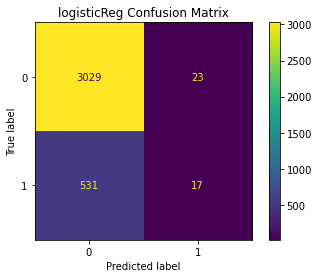

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3052
           1       0.33      0.00      0.01       548

    accuracy                           0.85      3600
   macro avg       0.59      0.50      0.46      3600
weighted avg       0.77      0.85      0.78      3600



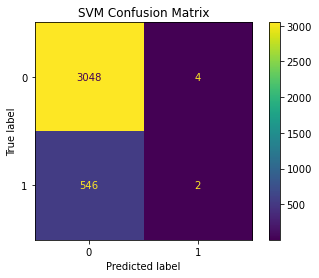

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3052
           1       0.00      0.00      0.00       548

    accuracy                           0.85      3600
   macro avg       0.42      0.50      0.46      3600
weighted avg       0.72      0.85      0.78      3600



/Users/robertson/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertson/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertson/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

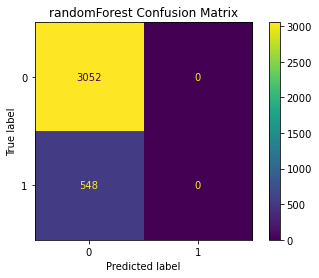

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3052
           1       0.53      0.03      0.06       548

    accuracy                           0.85      3600
   macro avg       0.69      0.51      0.49      3600
weighted avg       0.80      0.85      0.79      3600



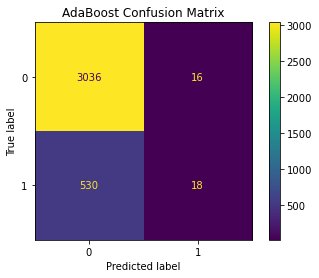

In [27]:
for i in Models.items():
    y_preds = i[1].predict(X_test)
    print(classification_report(y_test, y_preds))
    cm = confusion_matrix(y_test, y_preds)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.title(f"{i[0]} Confusion Matrix")
    plt.show()

***
### SMOTE

In [28]:
# conda install -c conda-forge imbalanced-learn

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [30]:
training_data = np.loadtxt('data/training.txt')
testing_data = np.loadtxt('data/testing.txt')

In [31]:
X_train, y_train = training_data[:,:-1], training_data[:,-1]
X_test, y_test = testing_data[:,:-1], testing_data[:,-1]

In [32]:
LR_smote = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', LogisticRegression())
    ])

param_grid_logisticReg = [
    {
        "classifier__C": [0.1, 0.5, 1, 10.0, 50.0],
        "classifier__class_weight": ['balanced', None]
    }
]

grid_search_LR_smote = GridSearchCV(LR_smote, param_grid_logisticReg, scoring='roc_auc', cv=10)
grid_search_LR_smote.fit(X_train, y_train)
# Hide the ouput using ;
;

''

In [33]:
print(grid_search_LR_smote.best_params_)
print(f'Best logisticReg auc Score: {grid_search_LR_smote.best_score_}')
LR_ = grid_search_LR_smote.best_estimator_

{'classifier__C': 50.0, 'classifier__class_weight': 'balanced'}
Best logisticReg auc Score: 0.6953464127186594


In [34]:
svm_smote = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', LinearSVC(dual=False))
    ])

param_grid_svm = [
    {
        "classifier__C": [0.1, 0.5, 1, 10.0, 50.0],
        "classifier__class_weight": ['balanced', None]
    }
]

grid_search_svm_smote = GridSearchCV(svm_smote, param_grid_svm, scoring='roc_auc', cv=10)
grid_search_svm_smote.fit(X_train, y_train)
# Hide the ouput using ;
;

''

In [35]:
print(grid_search_svm_smote.best_params_)
print(f'Best svm_smote auc Score: {grid_search_svm_smote.best_score_}')
SVM_ = grid_search_svm_smote.best_estimator_

{'classifier__C': 1, 'classifier__class_weight': None}
Best svm_smote auc Score: 0.694993598355862


In [36]:
RF_smote = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', RandomForestClassifier(max_features='sqrt'))
    ])

param_grid_rf = [
    {
        "classifier__n_estimators": [100,200],
        "classifier__max_depth": [10,20,40]
    }
]

grid_search_RF_smote = GridSearchCV(RF_smote, param_grid_rf, scoring='roc_auc', cv=10)
grid_search_RF_smote.fit(X_train, y_train)
# Hide the ouput using ;
;

''

In [37]:
print(grid_search_RF_smote.best_params_)
print(f'Best RF_smote auc Score: {grid_search_RF_smote.best_score_}')
RF_ = grid_search_RF_smote.best_estimator_

{'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best RF_smote auc Score: 0.689581314121898


In [38]:
base_tree = DecisionTreeClassifier(max_depth=1)
Ada_smote = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', AdaBoostClassifier(base_estimator=base_tree))
    ])

param_grid_Ada = [
    {  "classifier__base_estimator__max_depth":[1,2],
        "classifier__n_estimators": [100,200],
        "classifier__learning_rate": [0.5,1,1.5]
    }
]

In [39]:
grid_search_Ada_smote = GridSearchCV(Ada_smote, param_grid_Ada, scoring='roc_auc', cv=10, verbose=True)
grid_search_Ada_smote.fit(X_train, y_train)
# Hide the ouput using ;
;

Fitting 10 folds for each of 12 candidates, totalling 120 fits


''

In [40]:
print(grid_search_Ada_smote.best_params_)
print(f'Best Ada_smote auc Score: {grid_search_Ada_smote.best_score_}')
Ada_ = grid_search_Ada_smote.best_estimator_

{'classifier__base_estimator__max_depth': 1, 'classifier__learning_rate': 1, 'classifier__n_estimators': 200}
Best Ada_smote auc Score: 0.7156977740687727


In [41]:
Models_smote = {'logisticReg_smote':LR_, 'SVM_smomte':SVM_, 'randomForest_smote':RF_, 'AdaBoost_smote':Ada_}

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.74      3052
         1.0       0.24      0.66      0.35       548

    accuracy                           0.63      3600
   macro avg       0.58      0.64      0.55      3600
weighted avg       0.81      0.63      0.68      3600



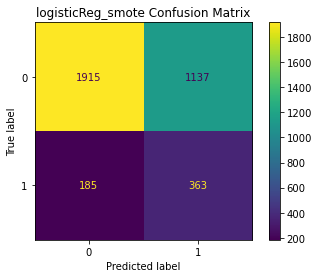

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.74      3052
         1.0       0.24      0.65      0.35       548

    accuracy                           0.63      3600
   macro avg       0.57      0.64      0.55      3600
weighted avg       0.81      0.63      0.68      3600



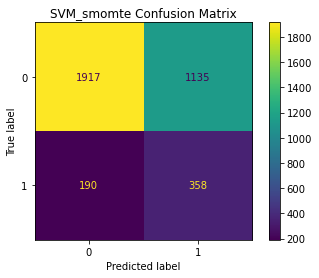

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      3052
         1.0       0.34      0.18      0.23       548

    accuracy                           0.82      3600
   macro avg       0.60      0.56      0.57      3600
weighted avg       0.78      0.82      0.80      3600



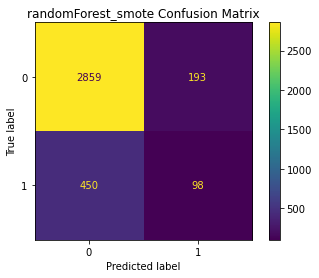

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91      3052
         1.0       0.46      0.11      0.18       548

    accuracy                           0.84      3600
   macro avg       0.66      0.54      0.55      3600
weighted avg       0.80      0.84      0.80      3600



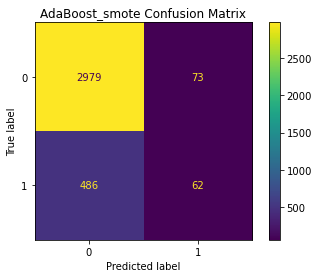

In [42]:
for i in Models_smote.items():
    y_preds = i[1].predict(X_test)
    print(classification_report(y_test, y_preds))
    cm = confusion_matrix(y_test, y_preds)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.title(f"{i[0]} Confusion Matrix")
    plt.show()